# Running DICE in Python

In this notebook, you will learn about the Dynamic Integrated Climate-Economy (DICE) model, a cornerstone in the history of climate economics. This notebook is addapted from the wonderful work by ClimateMatch at https://comptools.climatematch.io/.

We will explore the inner workings of the DICE model, starting with the foundational principles of economics: *utility* and *welfare* functions. You will also learn how these functions aggregate and weight the satisfaction derived from consumption across different societal groups. You will also learn how the these functions incorporate uncertain future utility into decision-making through *discount rates*. Valuing future states of the world allows the DICE model to place a value on its projections of future scenarios.

Later in the tutorial you will learn about damage functions, which combine climatological and economic knowledge to estimate how climate changes will affect economic productivity and the resultant well-being of society.

Finally, you will diagnose optimal planning within the DICE model, determining the best strategies for savings and emissions reduction rates (where _best_ is with respect to a chosen utility and welfare function). 

The overall objective of this tutorial is to provide a technical understanding of how parameters related to the distribution of value in society impact the optimal climate policy within a relatively simple IAM.

# Imports and Setup

In [1]:
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dicelib  # https://github.com/mptouzel/PyDICE

import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

%matplotlib inline
sns.set_style("ticks", {"axes.grid": False})
params = {"lines.linewidth": "3"}
plt.rcParams.update(params)
display(HTML("<style>.container { width:100% !important; }</style>"))

# Helper Functions

In [2]:
def plot_future_returns(gamma, random_seed):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    np.random.seed(random_seed)
    undiscounted_utility_time_series = np.random.rand(time_steps)
    ax[0].plot(undiscounted_utility_time_series)

    discounted_utility_time_series = undiscounted_utility_time_series * np.power(
        gamma, np.arange(time_steps)
    )
    ax[0].plot(discounted_utility_time_series)

    cumulsum_discounted_utility_time_series = np.cumsum(discounted_utility_time_series)
    ax[1].plot(
        cumulsum_discounted_utility_time_series * (1 - gamma),
        color="C1",
        label=r"discounted on $1/(1-\gamma)=$"
        + "\n"
        + r"$"
        + str(round(1 / (1 - gamma)))
        + "$-step horizon",
    )
    cumulsum_undiscounted_utility_time_series = np.cumsum(
        undiscounted_utility_time_series
    )
    ax[1].plot(
        cumulsum_undiscounted_utility_time_series
        / cumulsum_undiscounted_utility_time_series[-1],
        label="undiscounted",
        color="C0",
    )
    ax[1].axvline(1 / (1 - gamma), ls="--", color="k")

    ax[0].set_ylabel("utility at step t")
    ax[0].set_xlim(0, time_steps)
    ax[0].set_xlabel("time steps into the future")
    ax[1].legend(frameon=False)
    ax[1].set_ylabel("future return (normalized)")
    ax[1].set_xlabel("time steps into the future")
    ax[1].set_xlim(0, time_steps)
    fig.tight_layout()

# Section 1: Background on IAM Economics and the DICE Model

The [Dynamic Integrated Climate-Economy (DICE)](https://www3.nd.edu/~nmark/Climate/DICE-simplified_2019.pdf) was the first prominent Integrated Assessment Model (IAM), a class of models economists use to inform policy decisions. Recall that IAMs couple a climate model to an economic model, allowing us to evaluate the two-way coupling between economic productivity and climate change severity. DICE is too idealized to be predictive, like other models (e.g., the limits to growth model `world3`), but DICE is still useful as a sandbox for exploring climate policy ideas, which is how we will use it here.

Let's begin with a brief description of IAMs and the DICE model:

- DICE is a fully aggregated (i.e., non-spatial) model, but otherwise contains the essence of many key components of more complex IAMs. 
- Unlike `world3`, IAMs usually have *exogeneous* (externally set) times series for variables, in addition to fixed world system parameters. These exogeneous variables are assumed to be under our society's control (e.g. mitigation). 
- IAMs come equipped with an objective function (a formula that calculates the quantity to be optimized). This function returns the value of a projected future obtained from running the world model under a given climate policy. This value is defined by time series of these exogeneous variables. In this sense, the objective function is what defines "good" in "good climate policy". 
- The computation in an IAM is then an optimization of this objective as a function of the time series of these exogeneous variables over some fixed time window. In DICE, there are two exogeneous parameters:
    - **$\mu(t)$**: time-dependent mitigation rate (i.e. emissions reduction), which limits warming-caused damages
    - **$S(t)$**: savings rate, which drives capital investment 
- The choices for the standard values of the parameters used in the DICE models have been critisized, and updated versions have been analyzed and proposed ([Hansel et al. 2020](https://www.nature.com/articles/s41558-020-0833-x);[Barrage & Nordhaus 2023](https://www.nber.org/papers/w31112)). Here, we look at the standard DICE2016 version of the model.

All DICE models (and most IAMs) are based on *Neo-classical economics*. This is an approach to economics that makes particular assumptions. For example, it is assumed that production, consumption, and valuation of goods and services are driven solely by the supply and demand model. 

### Section 1.1.1: Utilities at Different Levels of Consumption
We assume

- **A unit of consumption has less value to an individual, the more that individual tends to consume overall**

The one parameter for the utility function used in DICE is **elasticity** ($\alpha$), which is the measure of a variable's sensitivity to change in another variable, in this case, how utility changes with consumption. 

We can plot the utility function for different values of elasticity to assess how the sensitivity of utility to changes in comsumption varies with different elasticity values.

Specifically, win the code below, we will e will plot $$U(c) = \frac{(c + 1)^{1-\alpha} - 1}{1-\alpha}$$ for different values of $\alpha$. 

Text(0, 0.5, 'utility, u(c)')

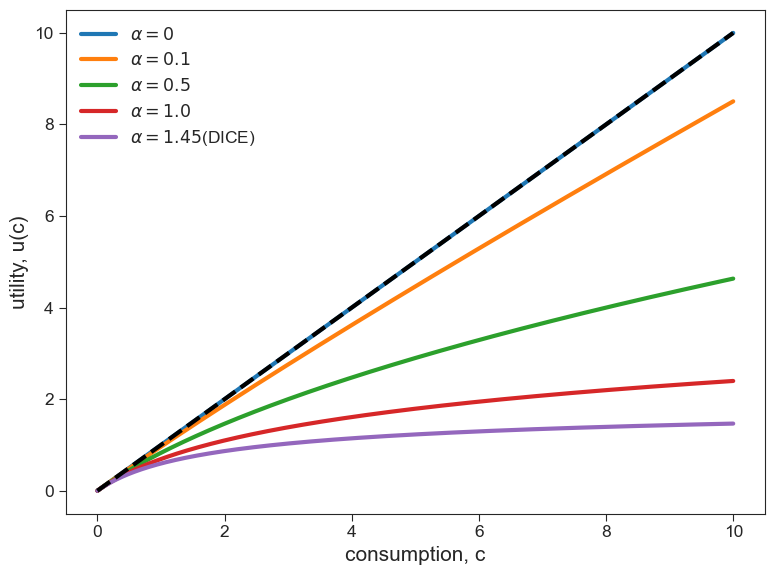

In [3]:
fig, ax = plt.subplots()
c = np.linspace(0, 10, 1000)
for alpha in [0, 0.1, 0.5, 1.0, 1.45]:
    if alpha == 1:
        ax.plot(c, np.log(1 + c), label=r"$\alpha=" + str(alpha) + "$")
    elif alpha == 1.45:
        ax.plot(
            c,
            ((c + 1) ** (1 - alpha) - 1) / (1 - alpha),
            label=r"$\alpha=" + str(alpha) + "$(DICE)",
        )
    else:
        ax.plot(
            c,
            ((c + 1) ** (1 - alpha) - 1) / (1 - alpha),
            label=r"$\alpha=" + str(alpha) + "$",
        )

ax.plot([0, 10], [0, 10], "k--")
ax.legend(frameon=False)
ax.set_xlabel("consumption, c")
ax.set_ylabel("utility, u(c)")

The plot you just made shows the relationship between consumption and utility for four different values of elasticity. For all values of elasticity, as consumption increases, the utility also increases, as we discussed above. However, let's make some observations about how changes in elasticity affect this relationship. For lower elasticity values (i.e. $\alpha$ = 1 shown in blue) an increase in consumption results in a stronger increase in utility. In constrast, for high elasticity values (i.e. $\alpha$ = 1.45 shown in red), such as what is used in the DICE model, an increase in consumption results in only a smaller increase in utility.

#### Questions 1.1.1
1. What do you think the function looks like for $\alpha=0$?

### Utility and Discounting 

In DICE, we assume  individuals are of the same type, i.e. a population of such individuals, and that **Utilities of individuals of the same type sum**

We also will discount our choices in the future via the discount rate, as discussed in previous classes. But to reiterate, **Utilities in the near future are valued more than those in the far future**

We have seen that discounting greatly depends on the  **discount factor** ($\gamma$ ('gamma'), which is a number just less than 1, e.g. 0.95). The discount factor is raised to the power of time (in years) into the future to give the discount rate at that future time: 
- after 1 year $(0.95)^1=0.95$
- after 2 years $(0.95)^2=0.90$
- after 10 years $(0.95)$<sup>10</sup>$=0.60$

The _return_ is the sum of future utilities, which is taken as the value of that future projection. If these utilies are discounted, their sum is called the _discounted return_. The following code will show an illustration of the effect of temporal discounting on future utilities and the return up to a given number of time steps into the future for a discount factor of $\gamma$ = 0.95.

**Here we see the value of future utility means almost nothing to the present-day decision**

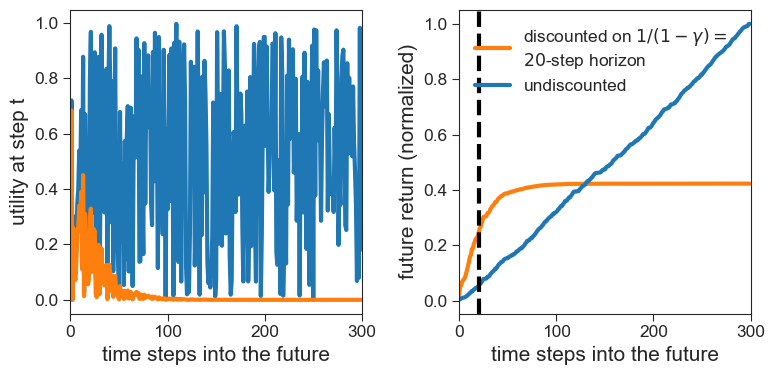

In [4]:
time_steps = 300
gamma = 0.95
random_seed = 1
plot_future_returns(gamma, random_seed)

In both plots, the blue lines are undiscounted case (i.e. without the effect of temporal discounting) and the orange lines are the discounted case (i.e. including the effect of temporal discounting). 

The figure on the left shows utility at each time step. In both the undiscounted scenario (blue) and the discounted scenario (orange), projected utilities are variable and uncertain. Notice that in the unsidcounted case, the average size of these utilities stays the same. In contrast, in the discounted case the typical size of utility rapidly decreases to zero, reflecting the effect of temporal discounting (i.e. the devaluation of utilities in the far future). 

The figure on the right shows changes in return (i.e. the cumulative sum of future utilities) over time. The black dashed line shows the effective time horizon beyond which rewards are ignored in the discounted case for this chosen value of the discount factor, $\gamma$ (this time is set by the natural convention of when the return gets to a fraction ($1-1/e\approx0.64$) of the final value). Beyond the time horizon, the future discounted return (orange) reaches saturation, and no additional utility from further time steps contributes to the overall value. In contrast, in the undiscounted case (blue), all future times are equally important, and the return grows linearly with the maximum time considered for computing utilities. 

#### Discussion question

Play around with the code above and see what discount factor would be necessary to have discounted utility not fall nearly to zero in the terminal year. What was it?

# Section 2: Damage Functions

Now that we have familiarized ourselves with some of the main components of IAMs and the DICE model, we can begin to explore another important component: the **damage function**. The damage function is a central model component that connects climate and socio-economic processes in integrated assessment models.

Damage functions are the objects in IAMs that dictate how changes in temperature affect production (e.g. through direct weather-related damages). They play a crucial role in determining the model's projections.

The standard form is a deterministic continuous function that maps changes in temperature, $\Delta T$, to the fraction of productivity that is destroyed by climate change every year, $\Omega$. The standard parametrization is a quadratic dependence 
$$\Omega=a \times (\Delta T)^2$$
where $a$ is some small constant (e.g. 0.001) whose value is set by regression of GDP and temperature over geographic and historical variation. Let's plot this function. 

(0.0, 0.5)

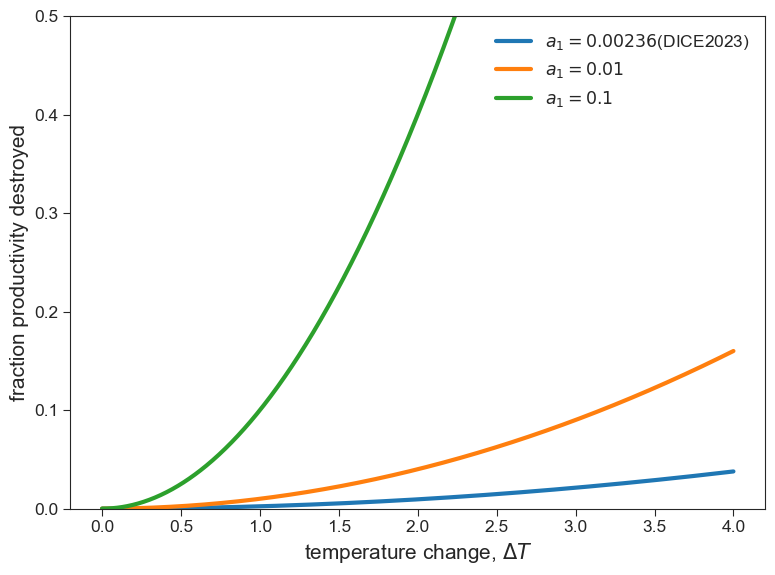

In [5]:
fig, ax = plt.subplots()
T = np.linspace(0, 4, 1000)
a1DICE = 0.00236
a2 = 2.00
for a1 in [a1DICE, 1e-2, 1e-1]:
    ax.plot(
        T,
        a1 * (T**a2),
        label=r"$a_1=" + str(a1) + "$" + ("(DICE2023)" if a1 == a1DICE else ""),
    )
ax.legend(frameon=False)
ax.set_xlabel("temperature change, $\Delta T$")
ax.set_ylabel("fraction productivity destroyed")
ax.set_ylim(0, 0.5)

Observe how larger temperature changes lead to a larger fraction of productivity destroyed due to the damages caused by that temperature. The damage at a given temperature scales linearly with the parameter $a_1$, and exponentially with the parameters $a_2$.

There are at least two fundamental problems with damage functions (for more see [*The appallingly bad neoclassical economics of climate change* by S. Keen in *Globalizations* (2020)](https://www.tandfonline.com/doi/full/10.1080/14747731.2020.1807856)):
1. As mathematical model objects, they are likely too simple to be useful predictors in characterizing climate damages in sufficient complexity. 
2. They arise from a poorly validated model-fitting procedure. In particular, it relies on ad hoc functional forms and the relevance of historical and geographical variability to future variability.

In [6]:
# to_remove explanation

"""
1. You can consider a few reasons such as nonlinearity, regional differences, socioeconomic factors, and non-monetary damages. In particular, one could imagine subway systems being minimally affected until the sea level rises to the level of entrances to the subway at which point the subway is completely flooded.
2. Significant in past and future: reduced worker productivity; Significant only in future: Heat-induced crop failures
""";

Despite these problems highlighting a pressing need to improve how we formulate climate damages, damage functions allow economists within the neoclassical paradigm to start seriously considering the damaging effects of climate change. After a few decades of economists using overly optimistic damage functions that downplayed the damaging effects of climate change, current research on damage functions is striving to incorporate more realism and better estimation.

For more contemporary damage functions see [van der Wijst et al. *Nat. Clim. Change* (2023)](https://www.nature.com/articles/s41558-023-01636-1). Note that even this modern publication is hindered by the [McNamara Fallacy](https://en.wikipedia.org/wiki/McNamara_fallacy) of leaving out things that are hard to measure. The authors state: "The climate change impacts did not include potential losses originated in ecosystems or in the health sector. This is motivated by the difficulty in addressing the non-market dimension of those impacts with a ‘market-transaction-based’ model such as CGE. Also, catastrophic events were not considered, even though some ‘extremes’ (riverine floods) were included."

## Section 2.1: IAM Model Summary 

We've now explored both the utility function and damage function components of IAMs.  Before we move on to actually running the DICE model, let's summarize what we've learned so far about IAMs, specifically regarding the economy and climate models:

The economy model in most IAMs is a capital accumulation model. 
- Capital ($K$) combines with a laboring population and technology to generate productivity ($Y$) that is hindered by climate damage. 
- A savings rate, $S$, drives capital accumulation, while the rest is consumed. Welfare is determined by consumption.
- Climate action is formulated by a mitigation rate, $\mu$, which along with the savings rate, $S$, are the two exogeneous control parameters in the model and are used to maximize welfare.

The climate model in DICE interacts with the economy model via the following equation: 
$$E_\mathrm{ind}=(1-\mu)\sigma Y,$$ 
- Productivity ($Y$) generates industrial emissions ($E_\mathrm{ind}$), where the $1-\mu$ factor accounts for a reduction of the carbon intensity of production, $\sigma$, via supply-side mitigation measures (e.g. increased efficiency). 
- The productivity $Y$ rather than output production ($Q$) is used here because damages aren't included. 
- Damages aren't included because the emissions produced in the process of capital production occur before climate change has a chance to inflict damage on the produced output. 
- These industrial emissions combine with natural emissions to drive the temperature changes appearing in the damage function, closing the economy-climate loop. 

## Section 2.2: Optimal Planning
The goal of the model is to maximize the overall value of a projected future, $V$, within the bounds of mitigation rate, $\mu$, and savings rate, $S$, time courses (while considering constraints on $\mu$ and $S$). This approach is known as **optimal planning**. But why does this "sweet spot" in which overall value is maximized exist? Increasing savings boosts investment and productivity, but higher production leads to higher emissions, resulting in increased temperature and damages that reduce production. Mitigation costs counterbalance this effect, creating a trade-off. As a result, there typically exists a meaningful joint time series of $\mu_t$ and $S_t$ that maximizes $V$. Due to the discount factor $\gamma$, $V$ depends on the future consumption sequence (non-invested production) within a few multiples of the time horizon, approximately $1/(1-\gamma)$ time steps into the future.

We gone over many variables so far in this tutorial. Here is a list of variables used fore easier reference:
- $K$ capital
- $Y$ productivity
- $S$ savings rate
- $\mu$ mitigation rate
- $E$ emissions
- $\sigma$ carbon intensity of production
- $Q$ production
- $\gamma$ discount factor
- $V$ value

If you'd like to explore the mathematical equations behind these models in more detail, please refer to the information in the "Further Reading" section for this day.

# Section 3: DICE Simulations


Now, let's move to the DICE model that gives us some control over our emissions and consumption to see the effect of varying the parameters arising from the above design choices.

I've forked an existing `Python` implementation of the [DICE2016 model](https://github.com/hazem2410/PyDICE) and refactored it into a class (defined in [`dicelib.py`](https://github.com/mptouzel/PyDICE/blob/master/dicelib.py)) and made a few other changes to make it easier to vary parameters. We'll use that [forked version](https://github.com/mptouzel/PyDICE/) in this tutorial.
Note that the DICE model was recently updated ([DICE2023](https://www.nber.org/papers/w31112)).

The model equations are described in a [document](https://github.com/hazem2410/PyDICE/blob/master/PyDICE2016.pdf) associated with the exising `Python` implementation.

## Section 3.1: Case 1 Standard Run

Let's run the standard run of the DICE model:

In [7]:
dice_std = dicelib.DICE()  # create an instance of the model
dice_std.init_parameters()
dice_std.init_variables()
controls_start_std, controls_bounds_std = dice_std.get_control_bounds_and_startvalue()
dice_std.optimize_controls(controls_start_std, controls_bounds_std);

c:\Users\dyyan\miniforge3\envs\8222env1\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4517.318953976377
            Iterations: 94
            Function evaluations: 19029
            Gradient evaluations: 94


Before assessing the results, let's first check that the optimal control solution is within the bounds we set. To do so, let's assess the mitigation rate and savings rate:

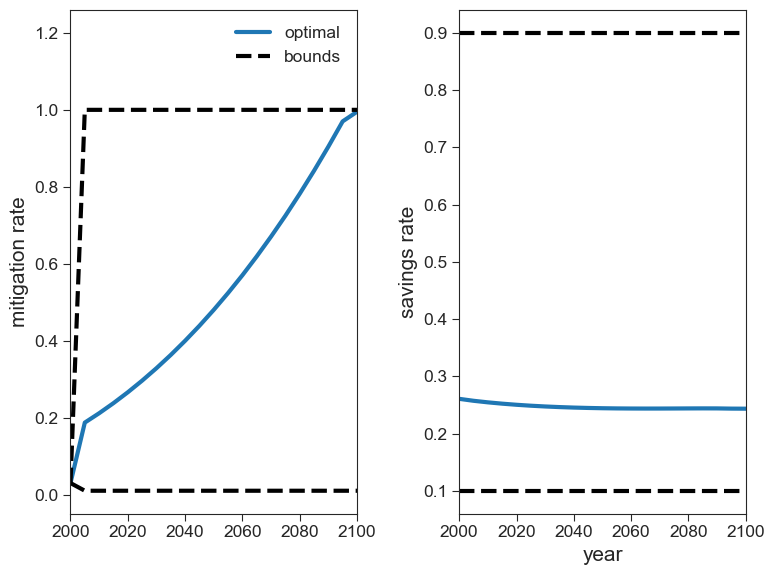

In [8]:
fig, ax = plt.subplots(1, 2)
max_year = 2100
TT = dice_std.TT
NT = dice_std.NT
upp, low = zip(*controls_bounds_std[:NT])
ax[0].plot(TT, dice_std.optimal_controls[:NT], label="optimal")
ax[0].plot(TT, upp, "k--", label="bounds")
ax[0].plot(TT, low, "k--")
ax[0].set_ylabel("mitigation rate")
ax[0].set_xlim(2000, max_year)
ax[0].legend(frameon=False)
upp, low = zip(*controls_bounds_std[NT:])
ax[1].plot(TT, dice_std.optimal_controls[NT:])
ax[1].plot(TT, upp, "k--")
ax[1].plot(TT, low, "k--")
ax[1].set_ylabel("savings rate")
ax[1].set_xlabel("year")
ax[1].set_xlim(2000, max_year)

fig.tight_layout()


The model incorporates the effects of negative emission technologies by allowing the mitigation rate (via the bounds) to exceed 1 around the year 2140. It is worth noting that the solution explicitly utilizes this feature and would do so even before 2100 if permitted. The decision to include this behavior was made by the modellers who realized that it enabled feasible solutions for the higher forcing SSP scenarios that were previously unattainable.

At the time, there was a lively debate surrounding this decision, although it was largely in favor of allowing mitigation rates greater than 1. As a result, such rates have become a standard feature in many models for high forcing regimes. However, it is important to acknowledge that there have been arguments against this practice, as discussed in [Anderson & Peters, 2006](https://DOI:10.1126/science.aah45).

In the final two tutorials, we will explore sociological aspects such as these.

Now, let's examine the remaining variables of the DICE model:

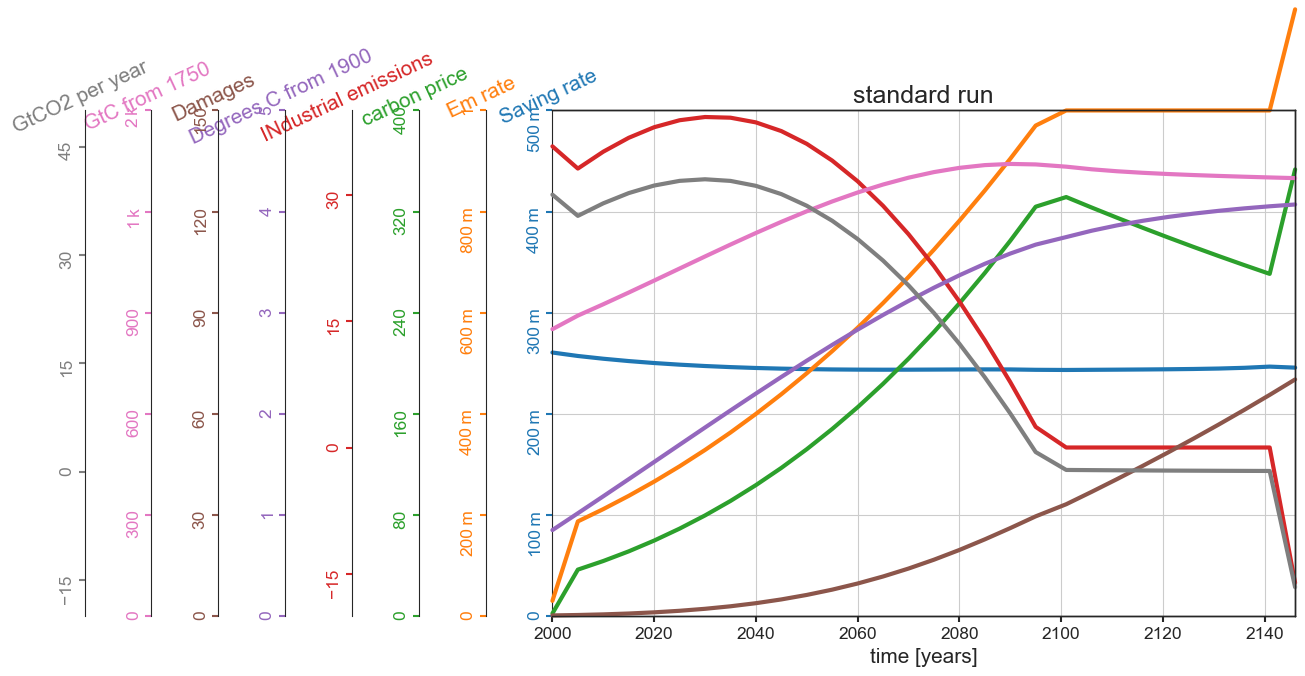

In [9]:
dice_std.roll_out(dice_std.optimal_controls)
dice_std.plot_run("standard run")

In this plot, the mitigation rate we looked at earlier is now referred to as the "Em rate" (orange line), which closely follows the patter of the carbon price (green line). Similarly, the rate of CO2 emissions (gray line) aligns with the industrial emissions (red line). Cumulative emissions (pink line) reach their peak around 2090, considering that negative emission technologies (NETs) are not employed until 2140.

## Hands on practice: Modifying the Damage Functions

Change the strength of the nonlinearity in the damage function by changing the exponent from 2 to 3.


In [10]:
# Reminder on some key python terms:

## To iterate ver a list, you use a for loop:
for i in [1, 2, 3]:
    print(i)
    
## The first step will be create a new dice model object. You will then call methods from that object like this: dice.method_name()

## Second step, use the init methods, but ensuring you use the correct damage function parameter

## One useful line you'll want is controls_start, controls_bounds = dice.get_control_bounds_and_startvalue()
## This just sets the two control variables to the starting values.


1
2
3
